In [1]:
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import skimage, skimage.transform, skimage.data
import skimage.feature, skimage.restoration

In [2]:
def getGaussian2D(npix, 
                  stdev=None,
                  fwhm=None):
    """Generates a circularly symmetric 2d gaussian pattern. 
    
    Ignoring the scaling constants, a circularly symmetric 2d gaussian can be calculated as:
    g = exp(-((x - cx)^2 + (y - cy)^2) / (2 * stdev^2))
    where x and y are the coordinate indices, cx and cy are the coordinates for the center
    of the gaussian, and stdev is the standard deviation. In this function, we assume that 
    cx = cy = npix // 2 (i.e. the center of the gaussian is the center of the 2d array).
    
    Parameters:
    npix - 
    Number of pixels in each axis of the probe
    
    stdev - 
    Standard deviation of the gaussian. The function requires either the standard deviation or the fwhm. 
    
    fwhm - 
    Full width at half maximum (FWHM) of the peak. The function requires either the standard deviation
    or the fwhm. If we supply the fwhm, the standard deviation is calculated as
    stdev = fwhm / 2.35682.
    
    Returns: 
    A 2d array of shape npix X npix and dtype float32.
    """
    
    
    if ((stdev is None) and (fwhm is None)) or ((stdev is not None) and (fwhm is not None)):
        raise KeyError("Should input only one of either stdev or fwhm.")
    if fwhm:
        stdev = fwhm / 2.35682
    
    center = npix // 2
    xvals = np.arange(npix)
    XX, YY = np.meshgrid(xvals, xvals)
    r_squared = (XX - center)**2 + (YY - center)**2
    
    # Ignoring the normalization constants
    gaussian = np.exp(-r_squared/ (2 * stdev**2)) 
    return gaussian.astype('float32')

In [3]:
def getSpeckle(npix, window_size):
    """Generates a speckle pattern. 
    
    To generate a speckle pattern, this function uses a window_size x window_size
    array of complex numbers with unit amplitude and uniformly random phase.
    This array is padded with zeros to get an npix x npix array, an FFT of which
    gives us a speckle pattern. The speckle pattern thus generated is discontinuous;
    there is a phase step of pi between adjacent pixels in both the x and y directions.
    We remove these discontinuities to get the final, continuous, speckle pattern.
    
    Parameters:
    
    npix - 
    Number of pixels along each side of the 2d array containing the speckle pattern.
    
    window_size - 
    The size of the rectangular window used to generate the speckle pattern. 
    Larger window sizes give smaller speckle sizes and vice versa. 
    (Note: I tried a circular window as well, but the results did not change 
    noticeably.)
    
    Returns:
    A 2d array of size npix x npix and dtype complex64.
    """
    
    if window_size > npix: 
        raise ValueError("Window size should be smaller than the size of output array.")
    
    # generating the random array
    ran = np.exp(1j * np.random.rand(npix,npix) * 2 * np.pi)
    
    window = np.zeros((npix, npix))
    indx1 = npix // 2 - window_size // 2
    indx2 = npix // 2 + window_size // 2
    window[indx1: indx2, indx1: indx2] = 1
    
    # Circular window - doesn't change the results.
    #xx, yy = np.meshgrid(np.arange(npix), np.arange(npix))
    #mask = ((xx - npix // 2)**2 + (yy - npix // 2)**2 < (window_size // 2)**2)
    #window[mask] = 1
    
    t = window * ran
    
    ft = np.fft.fftshift(np.fft.fft2(t, norm='ortho'))
    absvals = np.abs(ft)
    angvals = np.angle(ft)
    
    # Removing the discontinuities in the phases 
    angvals[::2] = (angvals[::2] + np.pi) % (2 * np.pi)
    angvals[:,::2] = (angvals[:, ::2] + np.pi) % (2 * np.pi)
    return (absvals * np.exp(1j * angvals)).astype('complex64')

In [4]:
def getSampleObj(npix=256, 
                 mod_range=1,
                 phase_range=np.pi):
    """Creates a sample object using stock data from the skimage module.
    
    Parameters:
    npix - 
    Number of pixels in each axis of the object
    
    mod_range - 
    Maximum value of the modulus for the object pixels.
    
    phase_range - 
    Maximum value of the phase for the object pixels.
    """
    mod_img = skimage.img_as_float(skimage.data.camera())[::-1,::-1]
    phase_img = skimage.img_as_float(skimage.data.immunohistochemistry()[:,:,0])[::-1,::-1]
    mod = skimage.transform.resize(mod_img, [npix, npix], 
                                   mode='wrap', preserve_range=True) * mod_range
    phase = skimage.transform.resize(phase_img, [npix,npix],
                                     mode='wrap', preserve_range=True) * phase_range
    return mod * np.exp(1j * phase)

In [5]:
def removePlaneFitFromPhase(test_phase):
    """Fits a plane to the phase.
    
    Unwraps the phase before the fitting procedure to remove the discontinuities at -pi <-> pi
    """
    b = skimage.restoration.unwrap_phase(test_phase).flatten()
    X = np.arange(test_phase.shape[1])
    Y = np.arange(test_phase.shape[0])
    XX, YY = np.meshgrid(X, Y)
    a = np.vstack((np.ones(XX.size), XX.flatten(), YY.flatten())).T
    
    params, residuals, rank, s = np.linalg.lstsq(a, b)
    phase_new = (b - a @ params).reshape(test_phase.shape)
    return phase_new

In [6]:
def registerImages(true_img, test_img):
    """When reconstucting both the object and the probe, the phase contains two kinds of artefacts:
    
    1) global phase shift.
    2) gradient in the phase with respect to the x and y axes. The gradient in the object phase
    is equal and opposite in sign to the gradient in the probe phase.
    
    By fitting a plane to the phase, we can remove both kinds of artefacts at once. 
    
    The true object might itself contain a gradient in the phase - I have to remove
    this gradient as well before I do a subpixel registration.
    """
    true_img_abs = np.abs(true_img)
    true_img_phase = np.angle(true_img)
    
    test_img_abs = np.abs(test_img)
    test_img_phase = np.angle(test_img)
    
    pix_shift, err, _ = skimage.feature.register_translation(true_img_abs, test_img_abs, upsample_factor=10)
    pix_shift = pix_shift.astype('int')
    test_img_rolled_abs = np.roll(test_img_abs, pix_shift, axis=(0,1))
    test_img_rolled_phase = np.roll(test_img_phase, pix_shift, axis=(0,1))
    
    true_img_phase_fitted = removePlaneFitFromPhase(true_img_phase)
    test_img_phase_fitted = removePlaneFitFromPhase(test_img_rolled_phase)
    
    true_img_new = true_img_abs * np.exp(1j * true_img_phase_fitted)
    test_img_new = test_img_rolled_abs * np.exp(1j * test_img_phase_fitted)
    
    pix_shift, err, phase_shift = skimage.feature.register_translation(true_img_new, test_img_new, upsample_factor=10)
    return [true_img_new, test_img_new], [pix_shift, err, phase_shift]

## Generating the object, the probe, and the diffraction intensities (with Poisson noise) ##

In [7]:
# Generating the object and the probe. 
# For convenience, I am not setting the detector pixel pitch - just working directly with the object plane 
obj_npix = 128
probe_npix = 64
n_photons = 1e6

gaussian_beam_stdev_pixels = 7
gaussian_intensity = getGaussian2D(probe_npix, stdev=gaussian_beam_stdev_pixels)
gaussian_ampl = gaussian_intensity**0.5

speckle = getSpeckle(probe_npix, 10)

probe_true = speckle * gaussian_ampl
probe_true = probe_true * np.sqrt(n_photons / np.sum(np.abs(probe_true)**2))
obj_true = getSampleObj(npix=obj_npix)

/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [8]:
# Generating diffraction patterns for the given number of scan points (in a square grid)
# Calculates the position so that the probe view always fits inside the object dimensions.
num_scan_steps_x = 12
grid_positions = np.floor(np.linspace(0, obj_npix - probe_npix, num_scan_steps_x)).astype('int')

diff_intensities = []
positions = []

for y in grid_positions:
    for x in grid_positions:
        exit_wave = obj_true[y: y + probe_npix, x: x + probe_npix] * probe_true
        exit_wave_ft = np.fft.fftshift(np.fft.fft2(exit_wave, norm='ortho'))
        diff_temp = np.abs(exit_wave_ft)**2
        diff_intensities.append(diff_temp)
        positions.append([y,x])
        
diff_intensites = np.array(diff_intensities)
# Adding poisson noise
diff_intensities = np.random.poisson(diff_intensities)

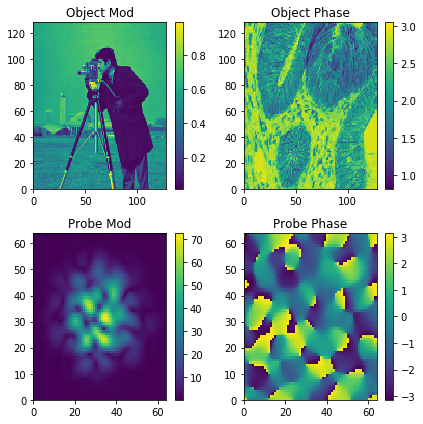

In [9]:
plt.figure(figsize=[6,6])
plot_items = [np.abs(obj_true), np.angle(obj_true), np.abs(probe_true), np.angle(probe_true)]
plot_titles = ['Object Mod', 'Object Phase', 'Probe Mod', 'Probe Phase']
for indx, item in enumerate(plot_items):
    plt.subplot(2, 2, indx + 1)
    plt.pcolormesh(item)
    plt.colorbar()
    plt.title(plot_titles[indx])
plt.tight_layout()
plt.show()

## Tensorflow reconstruction ##



In [10]:
# Initialize the probe with a backpropagation
# Random initalization for the object

probe_init = np.fft.fftshift(np.fft.ifft2(np.mean(np.sqrt(diff_intensities), axis=0)))
obj_init = np.random.random(obj_true.shape) * np.exp(1j * np.pi * np.random.random(obj_true.shape))

In [11]:
# Creating the variables for the reconstruction

tf.reset_default_graph()
tf_obj_real = tf.Variable(np.real(obj_init), dtype='float32')
tf_obj_imag = tf.Variable(np.imag(obj_init), dtype='float32')

tf_probe_real = tf.Variable(np.real(probe_init), dtype='float32')
tf_probe_imag = tf.Variable(np.imag(probe_init), dtype='float32')

tf_obj = tf.complex(tf_obj_real, tf_obj_imag)
tf_probe = tf.complex(tf_probe_real, tf_probe_imag)

ndiffs, npix, _ = diff_intensities.shape
shifted_intensities = np.fft.fftshift(diff_intensities, axes=(1,2))
tf_intensities = tf.constant(shifted_intensities, dtype='float32')

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
# Defining the amplitude-based loss, using the entire data set at once.
# Creating batches is somewhat complicated, and beyond the scope of this notebook.
# This implmentation is simple conceptually but not the most efficient.
tf_obj_views_all = []
for i, (y, x) in enumerate(positions):
    this_obj_view = tf_obj[y: y + npix, x: x + npix]
    tf_obj_views_all.append(this_obj_view)

tf_obj_views_all = tf.stack(tf_obj_views_all)
tf_exit_waves = tf_obj_views_all * tf_probe
tf_fts = tf.fft2d(tf_exit_waves) / npix
loss = tf.reduce_mean((tf.abs(tf_fts) - tf.sqrt(tf_intensities))**2)

In [13]:
# For simplicity, I am using the Adam optimizer. 
# Using the lipschitz constants for the learning rates in a gradient descent process is quite complicated. 

# The learning rates were obtained through trial and error.
obj_optimizer = tf.train.AdamOptimizer(1e-2)
probe_optimizer = tf.train.AdamOptimizer(1e0)

probe_min = probe_optimizer.minimize(loss, var_list=[tf_probe_real, tf_probe_imag])
obj_min = obj_optimizer.minimize(loss, var_list=[tf_obj_real, tf_obj_imag])

In [14]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [15]:
lossvals_array = []

In [16]:
# Actual minimization procedure. 
# Minimizing both the probe and the object simultaneously.
for i in range(500):

    temp1, temp2, lossval = session.run([probe_min, obj_min, loss])
    if i % 50 == 0:
        print('Iterations = {i}   Loss = {lossval}'.format(i=i, lossval=lossval))
    
    lossvals_array.append(lossval)
    
    if lossval < 1e-5:
        break

recons_obj = session.run(tf_obj)
recons_probe = session.run(tf_probe)
print('Current loss is', lossvals_array[-1])

Iterations = 0   Loss = 49.6693115234375
Iterations = 50   Loss = 8.899714469909668
Iterations = 100   Loss = 5.637563705444336
Iterations = 150   Loss = 4.9463300704956055
Iterations = 200   Loss = 4.549098491668701
Iterations = 250   Loss = 4.085322380065918
Iterations = 300   Loss = 2.4937984943389893
Iterations = 350   Loss = 0.8309453129768372
Iterations = 400   Loss = 0.689832866191864
Iterations = 450   Loss = 0.6516678333282471
Current loss is 0.63744086


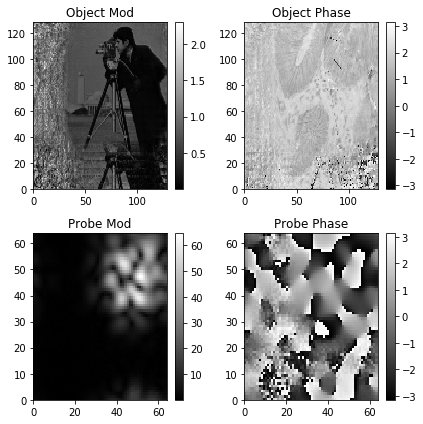

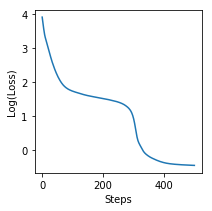

In [17]:
plt.figure(figsize=[6,6])
plot_items = [np.abs(recons_obj), np.angle(recons_obj),
              np.abs(recons_probe), np.angle(recons_probe)]
plot_titles = ['Object Mod', 'Object Phase', 'Probe Mod', 'Probe Phase']
for indx, item in enumerate(plot_items):
    plt.subplot(2, 2, indx + 1)
    plt.pcolormesh(item, cmap='gray')
    plt.colorbar()
    plt.title(plot_titles[indx])
plt.tight_layout()
plt.show()

plt.figure(figsize=[3,3])
plt.plot(np.log(lossvals_array))
plt.xlabel('Steps')
plt.ylabel('Log(Loss)')
plt.show()

In [18]:
# Calculating the reconstruction errors using the plane fitting procedure
# Note that the error thus calculated does not account for the lack of probe overlap at the edges of the object.
# Hence, the error calculated is an overestimate.
imgs, errs = registerImages(obj_true, recons_obj)
print('Reconstruction error', errs[1])


Reconstruction error 0.5554291349232361


/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if sys.path[0] == '':
